In [1]:
import sys
import os
sys.path.insert(0, os.getcwd()+"/Utils")
sys.path.insert(0, os.getcwd()+"/Models")
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from skimage.color import label2rgb
import unet2dstatic
import generate_mask_files
import augmentation_generator
from imp import reload

reload(generate_mask_files)
reload(augmentation_generator)
reload(unet2dstatic)

Using TensorFlow backend.


<module 'unet2dstatic' from 'C:\\Users\\smr-core\\Documents\\python\\ImageSegmentation/Models\\unet2dstatic.py'>

In [2]:
Color_Dict = {
    'background': np.array([0, 0, 0, 0]),
    'goblet': np.array([255,127,14, 255]),
    'microvilli': np.array([31,110,180,255]),
    'nucleus': np.array([44, 160, 44, 255]),
    'basement': np.array([214, 39, 40, 255])   
}

category_labels = ['nucleus']
#category_labels = ['background','nucleus', 'microvilli','goblet','basement']

model_inputs = {
      "image_height": 256,
      "image_width": 256,
      "input_channels": 1,
      "categories": len(category_labels),
      "category_labels": category_labels,
      "mask_color_dict": Color_Dict,
      "validation_split": 0.1,
      "epochs": 5,
      "batch_size": 5,
      "filename": os.path.join(os.getcwd(),'Unet2D-multicat-trained.h5'),
      "stop_after": 10,
      "image_count": 1000,
      "image_directory": os.path.join(os.getcwd(), 'Training', 'Approved_Raw_Images'),
      "mask_directory":  os.path.join(os.getcwd(), 'Training', 'Masks', 'nucleus'),
      "training_directory": os.path.join(os.getcwd(), 'Training', 'Masks'),
      "test_split": 0.2
    }

if len(category_labels)==1:
    model_inputs['filename'] = os.path.join(os.getcwd(),'Unet2D-singlecat-trained.h5')

In [ ]:
model_outputs={}
model_outputs['generated_mask_files'] = generate_mask_files.create_masks(model_inputs)

In [117]:
from skimage.io import imread

def convert_to_4d(image):
    image_4d = np.expand_dims(np.expand_dims(image, 2),3)
    return(image_4d)

def read_image(fn):
    img = imread(fn, dtype = np.uint8)
    return(img)

def get_slice_info():
    X_filenames = [fn for fn in os.listdir(model_inputs['image_directory']) if fn.startswith('SemImage')]
    Y_filenames = [fn for fn in os.listdir(model_inputs['mask_directory']) if fn.startswith('SemImage')]
    X_filepaths = [os.path.join(model_inputs['image_directory'],name) for name in X_filenames]
    Y_filepaths = [os.path.join(model_inputs['mask_directory'],name) for name in Y_filenames]

    slices = [0 for ind in range(len(X_filenames))]
    for ind, fn in enumerate(X_filenames):
        z = np.uint32(fn[8:11]) # really janky, just pulls the 3-digit z-stack ID by removing first 8 characters
        id_num = fn.split('_')[1].split('.png')[0] # pulls the mTurk ID, e.g., 'L7504'
        image = read_image(X_filepaths[ind])
        mask = read_image(Y_filepaths[ind])
        image_tensor = convert_to_4d(read_image(X_filepaths[ind]))
        mask_tensor = convert_to_4d(read_image(Y_filepaths[ind]))

        slices[ind] = {
            'z':z,
            'id_num':id_num,
            'image':image,
            'mask':mask,
            'image_tensor':image_tensor,
            'mask_tensor':mask_tensor
        }
        #slices[ind] = Slice(z, id_num, image, mask, image_tensor, mask_tensor)

    slice_info = {
        'z':[slc['z'] for slc in slices],
        'id_num':[slc['id_num']for slc in slices],
        'image':[slc['image'] for slc in slices],
        'mask':[slc['mask'] for slc in slices],
        'image_tensor':[slc['image_tensor'] for slc in slices],
        'mask_tensor':[slc['mask_tensor'] for slc in slices]
    }

    return(slices, slice_info)

def get_next_slice(current_z):
    closest_z_found_so_far = np.max(slice_info['z'])
    for ind, z in enumerate(slice_info['z']): 
        if ((z < closest_z_found_so_far) and (z > current_z)):
            closest_z_found_so_far = z
            
        next_slice_ind = slice_info['z'].index(closest_z_found_so_far)
    return(closest_z_found_so_far, next_slice_ind)

def get_prev_slice(current_z):
    closest_z_found_so_far = np.min(slice_info['z']) 
    for ind, z in enumerate(slice_info['z']): 
        if ((z > closest_z_found_so_far) and (z < current_z)):
            closest_z_found_so_far = z
        prev_slice_ind = slice_info['z'].index(closest_z_found_so_far)
    return(closest_z_found_so_far, prev_slice_ind)

def get_stack_info(current_slice_idx):
    current_z = slices[current_slice_idx]['z']
    (prev_slice_z, prev_slice_idx) = get_prev_slice(current_z)
    (next_slice_z, next_slice_idx) = get_next_slice(current_z)
    
    stack_raw = {
        'center_z_value':current_z,
        'z_values':[prev_slice_z, current_z, next_slice_z],
        'slice_indices':[prev_slice_idx, current_slice_idx, next_slice_idx],
        'slices':[slices[prev_slice_idx], slices[current_slice_idx], slices[next_slice_idx]],
        'tensor':np.concatenate((slices[prev_slice_idx]['image_tensor'], 
                                slices[current_slice_idx]['image_tensor'],
                                 slices[next_slice_idx]['image_tensor']),
                                axis = 2),
        '3dtensor':np.squeeze(a = np.concatenate((slices[prev_slice_idx]['image_tensor'], 
                              slices[current_slice_idx]['image_tensor'],
                              slices[next_slice_idx]['image_tensor']),
                              axis = 2),
                              axis = 3), # remove the 4th dimension, possibly useful for Augmentor
        'output_mask':slices[current_slice_idx]['mask'],
        'output_mask_tensor':slices[current_slice_idx]['mask_tensor']
    }
    
    return(stack_raw)


    
    

In [118]:
slices, slice_info = get_slice_info()
stack_info = [get_stack_info(ind) for ind, current_slice in enumerate(slices)]

In [172]:
pipeline_input = [[stack['3dtensor'], stack['output_mask']] for stack in stack_info]
#pipeline_input = [[stack['tensor'], stack['output_mask']] for stack in stack_info]
#pipeline_input = [[stack['tensor'] for stack in stack_info], 
#                  [stack['output_mask'] for stack in stack_info]]
p = Augmentor.DataPipeline(pipeline_input)
p.resize(width=model_inputs['image_width'],height=model_inputs['image_height'], probability=1)
p.flip_left_right(probability = 0.5)
p.flip_top_bottom(probability = 0.5)
p.rotate90(probability=0.5)
p.rotate270(probability=0.5)
p.zoom_random(probability = 0.2, percentage_area = 0.95)

In [108]:
qtconsole

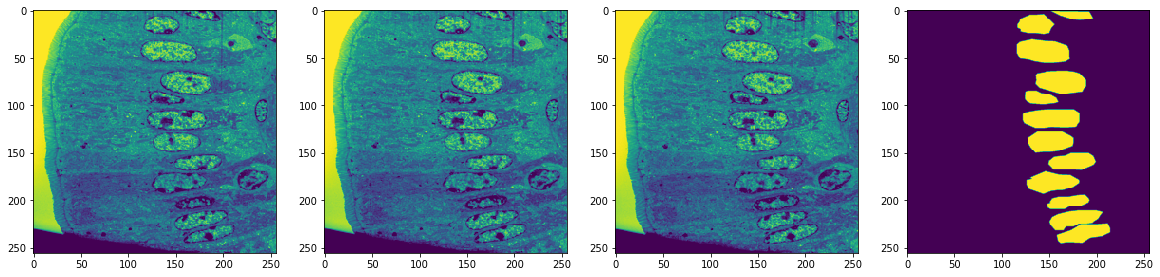

In [190]:
def plot_test_image(pipeline):
    test_image = pipeline.sample(1)
    f, axarr = plt.subplots(nrows = 1, ncols = 4, figsize=(20,15))
    axarr[0].imshow(test_image[0][0][:,:,0])
    axarr[1].imshow(test_image[0][0][:,:,1])
    axarr[2].imshow(test_image[0][0][:,:,2])
    axarr[3].imshow(test_image[0][1])
        
plot_test_image(p)



In [ ]:
def generator_3d(pipeline, batch_size):
    while True:
        X_images = []
        Y_images = []
        for ii in range(batch_size):
            images = pipeline.sample(1)[0]
            X_images.append(np.expand_dims(images[0],-1))
            Y_images.append(np.expand_dims(images[1],-1))
        
        X_images = img_as_float(X_images).astype('float32')
        
        Y_images = np.greater(Y_images,0).astype('float32')
        
        yield (X_images,Y_images)

In [8]:
if model_inputs['categories'] ==1:
    generator_training  = augmentation_generator.single_generator(pipeline, model_inputs['batch_size'])
    generator_validation = augmentation_generator.single_generator(pipeline, model_inputs['batch_size'])
else:
    generator_training = augmentation_generator.multi_generator(pipeline, model_inputs['batch_size'])
    generator_validation = augmentation_generator.multi_generator(pipeline, model_inputs['batch_size'])

## Load Model

In [11]:
import unet2dstatic
earlystopper = EarlyStopping(patience = model_inputs['stop_after'], verbose=0)
checkpointer = ModelCheckpoint(model_inputs['filename'], verbose=1, save_best_only = True)
callback_list = [earlystopper, checkpointer]

if not os.path.isfile(model_inputs['filename']):
    categories         = model_inputs['categories']
    
    input_size         = (model_inputs['image_height'],
                          model_inputs['image_width'],
                          model_inputs['input_channels'])
    
    model = unet2dstatic.unet(pretrained_weights = None, input_size = input_size, channels = categories)

else:
    if model_inputs['categories']==1:
        custom_obj = { 'dice_coef_loss': unet2dstatic.dice_coef_loss, 'dice_coef': unet2dstatic.dice_coef }
        model =  load_model(model_inputs['filename'], custom_objects=custom_obj)
    else:     
        model = load_model(model_inputs['filename'])
    

C:\users\aduen\Projects\Image_Seg\ImageSegmentation/Models\unet2dstatic.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = activation)


## Train Model

In [12]:
# model = load_model(model_inputs['filename'], custom_objects={ 'dice_coef_loss': unet2dstaticSingle.dice_coef_loss, 'dice_coef': unet2dstaticSingle.dice_coef })
results = model.fit_generator(generator        = g,
                              validation_data  = gv, 
                              steps_per_epoch  = model_inputs['image_count'],
                              validation_steps = int(model_inputs['image_count']*model_inputs['validation_split']),
                              epochs           = model_inputs['epochs'],
                              callbacks=callback_list)

Epoch 1/5
   5/1000 [..............................] - ETA: 55:28 - loss: 0.5614 - dice_coef: 0.1694  

KeyboardInterrupt: 

## Visualize Results

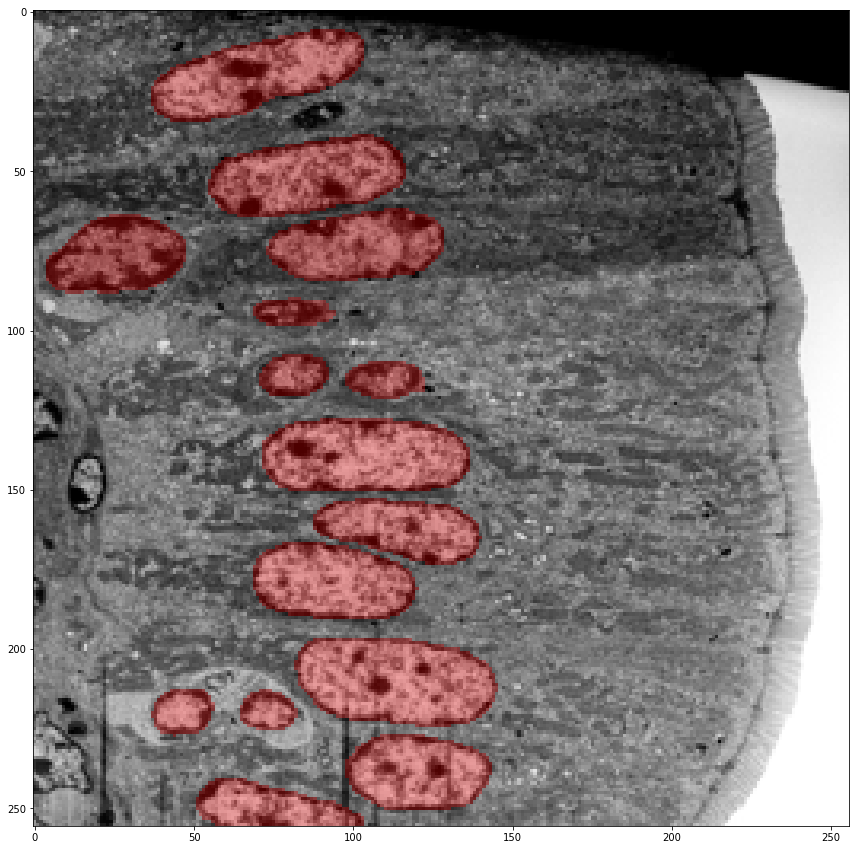

In [24]:
augmented_images = np.asarray(p.sample(2)[0][0])

f, axarr = plt.subplots(1, 1, figsize=(20,15))
if model_inputs['categories']==1:
    custom_obj = { 'dice_coef_loss': unet2dstatic.dice_coef_loss, 'dice_coef': unet2dstatic.dice_coef }
    best_model =  load_model(model_inputs['filename'], custom_objects=custom_obj)
else:     
    best_model = load_model(model_inputs['filename'])

predict = best_model.predict(np.expand_dims(np.expand_dims(augmented_images,0),-1))
predict = predict.reshape(256,256,model_inputs['categories'])*255//1

threshold = 10
if model_inputs['categories']==1:
    nucleus =  np.greater(predict[:,:,0],np.min(predict[:,:,0])*threshold)*1
    mask = (nucleus).astype('uint8')
    mask_layer = label2rgb(mask, image=augmented_images, colors=None, alpha=0.3, bg_label=0, bg_color=None, image_alpha=1)
    plt.imshow(mask_layer)
else:
    nucleus =  np.greater(predict[:,:,1],np.min(predict[:,:,1])*threshold)*1
    microvilli =  np.greater(predict[:,:,2],np.min(predict[:,:,2])*threshold)*2
    goblet =  np.greater(predict[:,:,3],np.min(predict[:,:,3])*threshold)*3
    basement =  np.greater(predict[:,:,4],np.min(predict[:,:,4])*threshold)*4
    mask = (nucleus+microvilli+goblet+basement).astype('uint8')
    mask_layer = label2rgb(mask, image=augmented_images, colors=None, alpha=0.3, bg_label=0, bg_color=None, image_alpha=1)
    plt.imshow(mask_layer)

## Cleanup

In [25]:
model_outputs['generated_mask_files'] = generate_mask_files.cleanup_masks(model_outputs['generated_mask_files'])